# Wake-T example: guided LPA with beamloading

### Import libraries

In [1]:
# import libraries
import scipy.constants as ct
import numpy as np
import copy

### Global optimization parameters

In [2]:
# Optimization parameters
# (relative variations w.r.t. nominal values)
# laser
intensity_factor = 0.0
tau_factor = 0.0
# plasma
plasma_density_factor = 0.  # 
# beam
beam_z_factor = 0.0  # 
beam_length_factor = 0.0
beam_i0_factor = 0.0
beam_i1_factor = 0.2

## Define plasma, laser and witness beam

In [3]:
# plasma density profile
factor = 1.  # <- rescale the global plasma density by this factor
np0 = (0.984e24 / factor) * (1. + plasma_density_factor)
ramp_up = 1e-3 * np.sqrt(factor)
# plateau = 1e-2
plateau = 2.5e-2 * np.power(factor, 3. / 2.)
ramp_down = 1e-3 * np.sqrt(factor)
ramp_decay_length = 0.5e-3 * np.sqrt(factor)
L_plasma = ramp_up + plateau + ramp_down
kp = np.sqrt(np0 * ct.e**2 / (ct.epsilon_0 * ct.m_e * ct.c**2))
lambdap = 2. * np.pi / kp
E0 = kp * ct.m_e * ct.c**2 / ct.e

def density_profile(z):
    # Allocate relative density
    n = np.ones_like(z)
    # Make ramp up
    n = np.where(z < ramp_up, 1 / (1 + (ramp_up - z) / ramp_decay_length)**2, n)
    # Make ramp down
    n = np.where( (z >= ramp_up + plateau) & (z < ramp_up + plateau + ramp_down),
            1 / (1 + (z - ramp_up - plateau) / ramp_decay_length)**2, n)
    # Make zero after downramp
    n = np.where( z >= ramp_up + plateau + ramp_down, 0, n)
    # Return absolute density
    return n * np0

In [4]:
# Laser parameters
#
lambda0 = 0.8e-6
# LUX parameters
a0 = 2.027246 * np.sqrt(1. + intensity_factor)
w0_orig = 22.352e-6 * np.sqrt(factor)
tau_fwhm = 33.414e-15 * np.sqrt(factor) * (1. + tau_factor)
tau = tau_fwhm / np.sqrt(2. * np.log(2))

# match laser spot size and focal position
from find_matching_func import find_matching

def upramp_profile(z, zp):
    n = density_profile(z)
    return n / np0

z_foc, w0 = find_matching(rm=w0_orig, lambda0=lambda0,
                          zp=ramp_up, ramp=upramp_profile)

# guiding channel depth
r_e = ct.e**2 / (4. * np.pi * ct.epsilon_0 * ct.m_e * ct.c**2)  # electron radius
rel_delta_n_over_w2 = 1. / (np.pi * r_e * w0**4 * np0)  # matched channel depth

# laser centroid comoving position
zmax = 0.  # right edge of the simulation
zl0 = zmax - 2. * ct.c * tau  # Laser centroid

# other laser parameters
k0 = 2. * np.pi / lambda0  # Laser wavenumber
PA = ct.epsilon_0 * ct.c**5 * ct.m_e**2 / ct.e**2  # Power constant
i0 = PA * a0**2 * k0**2 / 2  # Laser peak intensity
El0 = k0 * ct.m_e * ct.c**2 * a0 / ct.e   # Laser peak electric field
zR = np.pi * w0**2 / lambda0  # Rayleigh length
P0 = (np.pi / 2) * i0 * w0**2  # Peak power
Ene0 = np.sqrt(2 * np.pi) * (tau / 2) * P0
# Laser spot size at the start of the simulation:
w_start = w0 * np.sqrt(1 + ((z_foc - zl0) / zR)**2)

In [5]:
# Witness bunch parameters (trapezoidal)
#
gamma0  = 100  # Lorentz factor (average)
sgamma0 = 0.005 * gamma0  # spread
emit0  = 1e-6  # normalized_emittance
kbeta = kp / np.sqrt(2. * gamma0)  # betatron wavenumber (blowout)
betax0 = 1. / kbeta   # matched beta
sx0 = np.sqrt(emit0 * betax0 / gamma0)  # matched beam size (rms)
i0 = 5.e3 * (1 + beam_i0_factor)  # current (left edge)
i1 = 5.e3 * (1 + beam_i1_factor)  # current (right edge)
n1 = i1 / (2. * np.pi * ct.c * ct.e * sx0**2)  # peak density
bunch_length = 4.7e-6 * np.sqrt(factor)  # bunch length (edge to edge distance)
sz0 = 0.1e-6  # gaussian decay
zc = zl0 - (3.6 * lambdap / 4.) * (1 + beam_z_factor)  # bunch center
z1 = zc + bunch_length / 2.
bunch_length = bunch_length * (1 + beam_length_factor)
z0 = z1 - bunch_length
zc = (z0 + z1) / 2. # bunch middle position
q_plat = (min(i0, i1) / ct.c) * bunch_length 
q_triag = ((max(i0, i1) - min(i0, i1)) / ct.c) * bunch_length / 2.
q_gaus0 = (i0 / ct.c) * np.sqrt(2 * np.pi) * sz0 / 2.
q_gaus1 = (i1 / ct.c) * np.sqrt(2 * np.pi) * sz0 / 2.
q_tot = q_plat + q_triag + q_gaus0 + q_gaus1  # bunch total charge
n_part = 1e4  # number of beam macroparticles
# bunch injection position:
zf = ramp_up + 2.05e-3 * np.power(factor, 3. / 2.)
# zf = 14e-3


## Wake-t configuration and run

In [6]:
# simulation box
L_box = 55e-6 * np.sqrt(factor)  # Box length
zmin = zmax - L_box      # Left  edge of the simulation box (meters)
rmax_plasma = 2.5 * w_start   # radius of the plasma column
rmax = 3.2 * w_start   # radius of the simulation box
dz_adv = 0.1e-6 * np.sqrt(factor)   # Advised longitudinal resolution
Nz_adv = int(L_box / dz_adv)
Nz   = Nz_adv      # Number of gridpoints along z
dr_adv = 0.1 / kp
# dr_adv = 0.2e-6
Nr_adv = int(rmax / dr_adv)
Nr = Nr_adv        # Number of gridpoints along r
# Particles per cell
ppc = 2
# Field update step
dz_fields = L_box

In [7]:
# create wake_t objects
from wake_t.beamline_elements import PlasmaStage
from wake_t import GaussianPulse
from wake_t.particles.particle_bunch import ParticleBunch
from wake_t.diagnostics import analyze_bunch, analyze_bunch_list
from bunch_utils import trapezoidal_bunch

# Laser object
laser = GaussianPulse(xi_c=zl0, l_0=lambda0, w_0=w0,
                      a_0=a0, tau=tau_fwhm, z_foc=z_foc)

# Generate bunch
x, y, z, ux, uy, uz, q = trapezoidal_bunch(i0, i1, n_part=n_part,
                                           gamma0=gamma0, s_g=sgamma0,
                                           length=bunch_length,
                                           s_z=sz0, emit_x=emit0, s_x=sx0,
                                           zf=zf, tf=(zf - zc) / ct.c)
# Bunch object
bunch = ParticleBunch(q, x, y, z, ux, uy, uz,
                      z_injection=zf,
                      name='bunch')

# Plasma stage: propagation length and diagnostics period
prop_length = 2.0 * zf
# Diagnostics period (meters)
diag_period = prop_length
# Number of diagnostic snapshots
N_diag = int(prop_length / diag_period)
prop_length = N_diag * diag_period
N_diag = N_diag + 1

# Plasma stage object
plasma = PlasmaStage(
    length=prop_length, density=density_profile, laser=laser,
    wakefield_model='quasistatic_2d', n_out=N_diag,
    laser_evolution=True,
    r_max=rmax, r_max_plasma=rmax_plasma, xi_min=zmin, xi_max=zmax,
    n_r=Nr, n_xi=Nz, dz_fields=dz_fields, ppc=ppc,
    parabolic_coefficient=rel_delta_n_over_w2)

In [8]:
# track the bunch through the plasma stage
bunch_list = plasma.track(bunch, out_initial=False, opmd_diag=True)


Plasma stage
------------
Tracking in 2 step(s)... [--------------------] Done (21.154 seconds).
--------------------------------------------------------------------------------


## Visualize and analyze

In [9]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'distance (mm)')

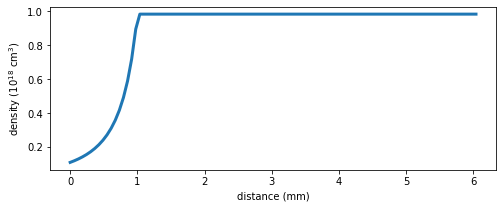

In [10]:
# plot plasma profile
fig, ax = plt.subplots(figsize=(8, 3))
z = np.arange(0., prop_length, prop_length / 100.)
ax.plot(z / 1e-3, density_profile(z) / 1e24, label='plasma', lw=3)
ax.set_ylabel('density ($\mathrm{10^{18}~cm^{3}}$)')
ax.set_xlabel('distance (mm)')

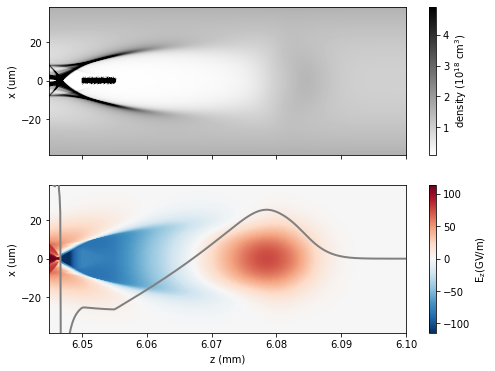

In [11]:
# plot fields
from openpmd_viewer import OpenPMDTimeSeries

# access data
iteration = N_diag - 1
ts = OpenPMDTimeSeries('./diags/hdf5', backend='h5py')

# get particle density
rho, info_rho = ts.get_field(iteration=iteration, field='rho')
nden = -rho / ct.e
# add bunch particle density to plasma
x, y, z, w = ts.get_particle( var_list=['x', 'y', 'z', 'w'], iteration=iteration, species='bunch')
nx, nz = rho.shape[0], rho.shape[1]
dx, dz = info_rho.dr, info_rho.dz
dy = dx
filter = (y >= -dy / 2) & (y <= dy / 2)  # filter particles to the central y-slice
x, z, w = x[filter], z[filter], w[filter]
extent = info_rho.imshow_extent
nden_bunch, *_ = np.histogram2d(z, x, bins=[nz, nx], range=[[extent[0], extent[1]],[extent[2], extent[3]]], weights=w)
nden_bunch = nden_bunch.T / (dy * dx * dz)
nden = nden + nden_bunch

# get longitudinal electric field
Ez, *_ = ts.get_field(iteration=iteration, field='E', coord='z')

# list of fields to plot
fields = [nden / 1e24, Ez / 1e9]
labels = ['density ($\mathrm{10^{18}~cm^{3}}$)', '$\mathrm{E_z (GV/m)}$']
cmaps = ['gray_r', 'RdBu_r']
vranges = [[0.1 * np0 / 1e24, 5 * np0 / 1e24], [-1.2 * E0 / 1e9, 1.2 * E0 / 1e9]]
extent[0:2] = extent[0:2] / 1e-3
extent[2:4] = extent[2:4] / 1e-6

npanels = len(fields)
fig, axs = plt.subplots(npanels, figsize=(4 * npanels, 6), sharex=True)
for i, ax in enumerate(axs):
    # plot 2D field 
    fieldax = ax.imshow(fields[i], extent=extent, aspect='auto', cmap=cmaps[i], vmin=vranges[i][0], vmax=vranges[i][1])
    # ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 0))
    if i == len(axs) - 1:
        ax.set_xlabel('z (mm)')
    ax.set_ylabel('x (um)')
    yrange = extent[3] - extent[2]
    ymid = (extent[3] + extent[2]) / 2
    # zoom in y direction
    ymin = ymid - yrange / 4
    ymax = ymid + yrange / 4
    ax.set_ylim(ymin, ymax)
    # set color bar
    cbar = fig.colorbar(fieldax, ax=ax)
    cbar.set_label(labels[i])
    # cbar.formatter.set_powerlimits((0, 0))
    if i == 0:
        continue
    # plot on-axis outline
    ax2 = ax.twinx()
    ax2.set_ylim(vranges[i][0], vranges[i][1])
    field0 = fields[i][int(nx / 2)][:]
    z = np.linspace(extent[0], extent[1], nz)
    ax2.plot(z, field0, color='gray', lw=2)
    plt.axis('off')

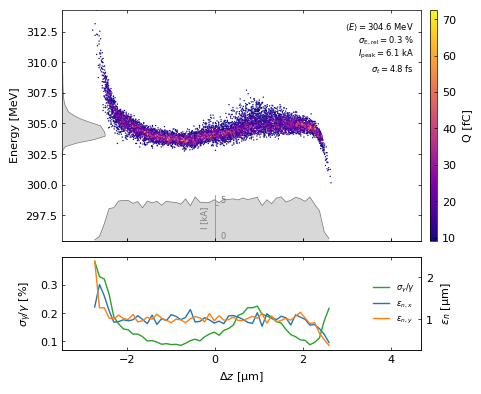

In [12]:
%%capture --no-display
# plot bunch
from aptools.plotting.quick_diagnostics import slice_analysis
fig = plt.figure(figsize=(5, 4), dpi=100)
slice_analysis(bunch.x, bunch.y, bunch.xi, bunch.px, bunch.py, bunch.pz,
               bunch.q, fig=fig)
plt.show()